# Lesson 4: Multimodal Retrieval from Vector Stores

<p style="background-color:#fff1d7; padding:15px; "> <b>Note:</b>
We'll use downloaded videos, extracted frames, transcription,
<br>and generated captions from Lesson 3. 
<br>
These data is already included in the symlinked folder `shared_folder`.
<br>
If you haven't already practiced the lesson 3, we pre-populated them.
</p>

## Setup

In [1]:
from mm_rag.embeddings.bridgetower_embeddings import (
    BridgeTowerEmbeddings
)
from mm_rag.vectorstores.multimodal_lancedb import MultimodalLanceDB
import lancedb
import json
import os
from PIL import Image
from utils import load_json_file
from utils import display_retrieved_results

### Setup LanceDB vectorstore

In [2]:
# declare host file
LANCEDB_HOST_FILE = "./shared_data/.lancedb"
# declare table name
TBL_NAME = "test_tbl"
# initialize vectorstore
db = lancedb.connect(LANCEDB_HOST_FILE)

## Ingest Video Corpuses to LanceDB Using Langchain

### Prepare Data

In [3]:
# load metadata files
vid1_metadata_path = './shared_data/videos/video1/metadatas.json' # metadata for videos from Preprocessing Videos for Multimodal RAG
vid2_metadata_path = './shared_data/videos/video2/metadatas.json' # metadata for videos from Preprocessing Videos for Multimodal RAG
vid1_metadata = load_json_file(vid1_metadata_path)
vid2_metadata = load_json_file(vid2_metadata_path)

# collect transcripts and image paths
vid1_trans = [vid['transcript'] for vid in vid1_metadata]
vid1_img_path = [vid['extracted_frame_path'] for vid in vid1_metadata]

vid2_trans = [vid['transcript'] for vid in vid2_metadata]
vid2_img_path = [vid['extracted_frame_path'] for vid in vid2_metadata]

<p style="background-color:#fff1d7; padding:15px; "> <b>Notes:</b>
<br>
- We observe that the transcripts of frames extracted from video1 are usually fragmented and even an incomplete sentence. E.g., <i>four more was just icing on the cake for a</i>. Thus, such transcripts are not meaningful and are not helpful for retrieval. In addition, a long transcript that includes many information is also not helpful in retrieval. A naive solution to this issue is to augment such a transcript with the transcripts of n neighboring frames. It is advised that we should pick an individual n for each video such that the updated transcripts say one or two meaningful facts.
<br>
- It is ok to have updated transcripts of neighboring frames overlapped with each other.
<br>
- Changing the transcriptions which will be ingested into vector store along with their corresponding frames will affect directly the performance. It is advised that one needs to do diligent to experiment with one's data to get the best performance.

</p>

In [6]:
# for video1, we pick n = 7
n = 7
updated_vid1_trans = [
 ' '.join(vid1_trans[i-int(n/2) : i+int(n/2)]) if i-int(n/2) >= 0 else
 ' '.join(vid1_trans[0 : i + int(n/2)]) for i in range(len(vid1_trans))
]

# also need to update the updated transcripts in metadata
for i in range(len(updated_vid1_trans)):
    vid1_metadata[i]['transcript'] = updated_vid1_trans[i]

In [5]:
print(f'A transcript example before update:\n"{vid1_trans[6]}"')
print()
print(f'After update:\n"{updated_vid1_trans[6]}"')

A transcript example before update:
"spacewalk and to now have the chance to have done"

After update:
"two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a a wonderful mission."


### Ingest Data to LanceDB

In [7]:
# initialize an BridgeTower embedder 
embedder = BridgeTowerEmbeddings()


# you can pass in mode="append" 
# to add more entries to the vector store
# in case you want to start with a fresh vector store,
# you can pass in mode="overwrite" instead 

_ = MultimodalLanceDB.from_text_image_pairs(
    texts=updated_vid1_trans+vid2_trans,
    image_paths=vid1_img_path+vid2_img_path,
    embedding=embedder,
    metadatas=vid1_metadata+vid2_metadata,
    connection=db,
    table_name=TBL_NAME,
    mode="overwrite", 
)

100%|██████████| 34/34 [00:17<00:00,  1.97it/s]


## Multimodal Retrieval Using Langchain

### Helper function

A helper function `display_retrieved_results` in `utils.py` to display retrieved results.

### Create Connection to a Table in LanceDB

In [8]:
# open a connection to table TBL_NAME
tbl = db.open_table(TBL_NAME)

print(f"There are {tbl.to_pandas().shape[0]} rows in the table")
# display the first 3 rows of the table
tbl.to_pandas()[['text', 'image_path']].head(3)

There are 34 rows in the table


,text,image_path
0,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...
1,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...
2,As I look back on the the mission that we've h...,./shared_data/videos/video1/extracted_frame/fr...


### Retrieval from LanceDB Vector Store using Langchain

In [9]:
# Creating a LanceDB vector store 
vectorstore = MultimodalLanceDB(
    uri=LANCEDB_HOST_FILE, 
    embedding=embedder, 
    table_name=TBL_NAME)

# creating a retriever for the vector store
# search_type="similarity" 
#  declares that the type of search that the Retriever should perform 
#  is similarity search
# search_kwargs={"k": 1} means returning top-1 most similar document
retriever = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 1}
)

There is/are 1 retrieved result(s)

The caption of the 1-th retrieved result is:
"The image features a young child, possibly a toddler, sitting on a pink playground slide. The child appears to be enjoying their time on the slide. 

In the background, there are two other people, one standing closer to the left side of the image and the other person standing further to the right. The scene seems to be set in a playground or a similar outdoor area."



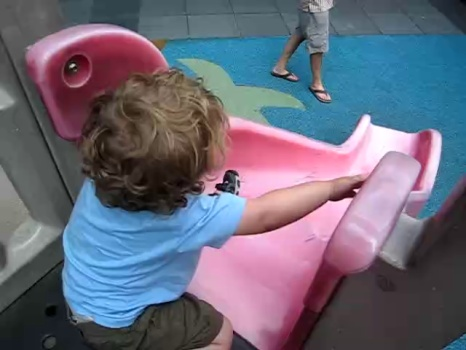

------------------------------------------------------------


In [10]:
query1 = "a toddler and an adult"
results = retriever.invoke(query1)
display_retrieved_results(results)

In [ ]:
# ask to return top 3 most similar documents
retriever = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 5})
results = retriever.invoke(query1)
display_retrieved_results(results)

There is/are 5 retrieved result(s)

The caption of the 1-th retrieved result is:
"The image features a young child, possibly a toddler, sitting on a pink playground slide. The child appears to be enjoying their time on the slide. 

In the background, there are two other people, one standing closer to the left side of the image and the other person standing further to the right. The scene seems to be set in a playground or a similar outdoor area."



### More Examples

There is/are 1 retrieved result(s)

The caption of the 1-th retrieved result is:
"the science activities that happened over the last two months. The view is always amazing I didn't think I would do another spacewalk and to now have the chance to have done four more was just icing on the cake for a"



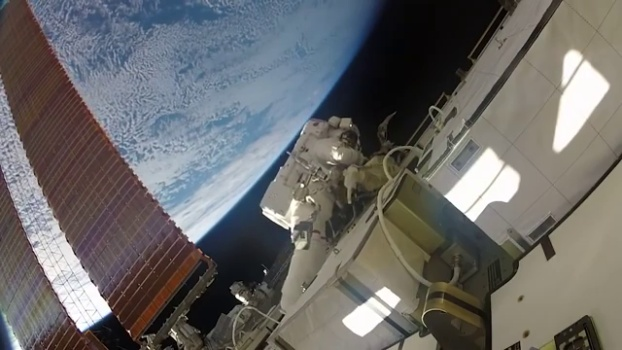

------------------------------------------------------------


In [12]:
retriever = vectorstore.as_retriever(
    search_type='similarity', 
    search_kwargs={"k": 1})
query2 = (
        "an astronaut's spacewalk "
        "with an amazing view of the earth from space behind"
)
results2 = retriever.invoke(query2)
display_retrieved_results(results2)

There is/are 1 retrieved result(s)

The caption of the 1-th retrieved result is:
"As I look back on the the mission that we've had here on the International Space Station, I'm proud to have been a part of much of the science activities that happened over the last two months."



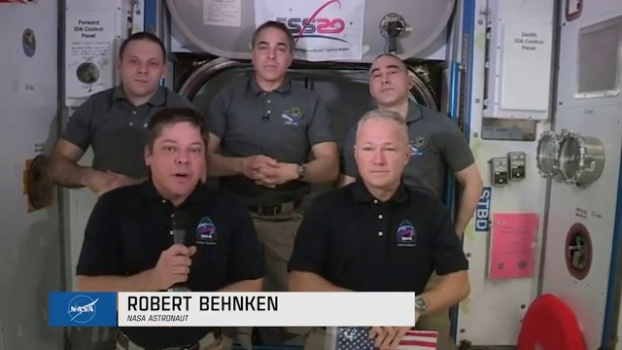

------------------------------------------------------------


In [13]:
query3 = "a group of astronauts"
results3 = retriever.invoke(query3)
display_retrieved_results(results3)